In [1]:
using Pkg
Pkg.activate("/Users/ryansenne/Documents/Github/ssm_julia/")
# Pkg.activate("/home/ryansenne/PycharmProjects/ssm_julia/")

  Activating project at `\Users\ryansenne\Documents\Github\ssm_julia`


In [2]:
include("/Users/ryansenne/Documents/Github/ssm_julia//src/SSM.jl")
# include("/home/ryansenne/PycharmProjects/ssm_julia/src/SSM.jl")
using Random
using .SSM
using Distributions
using Plots
using LinearAlgebra
using ForwardDiff
using StatsFuns
using Optim

In [7]:
# generate some data from a PPCA model
z = randn(1000, 2)
W = randn(3, 2)

data = z * W' + randn(1000, 3)

ppca = ProbabilisticPCA(K=2, D=3)


ll = SSM.fit!(ppca, data)

42-element Vector{Any}:
   -Inf
 -5338.984210790628
 -5295.294748669258
 -5286.531461317564
 -5281.740256654797
 -5277.632880803926
 -5273.144681203926
 -5268.115464756806
 -5262.864145275606
 -5257.879122579448
     ⋮
 -5242.029563400106
 -5242.029494430534
 -5242.0294548783795
 -5242.029432629463
 -5242.029420467294
 -5242.02941411315
 -5242.0294110457135
 -5242.029409791401
 -5242.029409498574

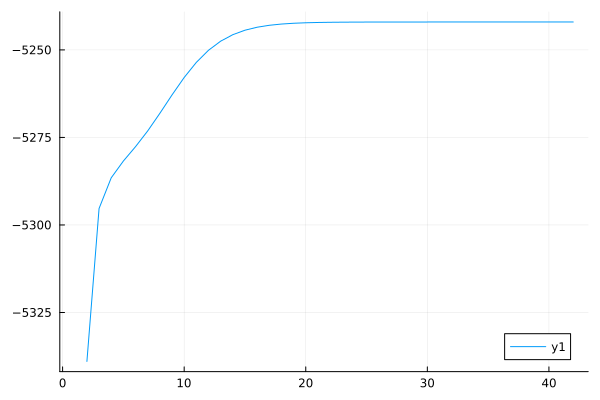

In [8]:
plot(ll)

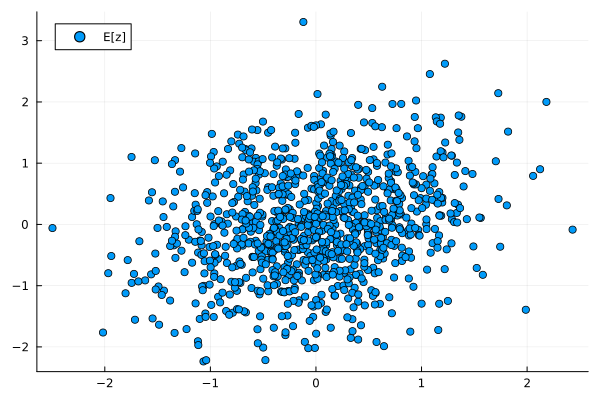

In [9]:
scatter(ppca.z[:, 1], ppca.z[:, 2], label="E[z]", legend=:topleft)

In [7]:
ppca.W

In [ ]:
# generate synthetic data
Random.seed!(123)

# set parameters
n = 1000
β = [0.1, 0.9]

# generate data
X = hcat(ones(n), randn(n, 1))

p = logistic.(X * β)
y = rand.(Bernoulli.(p));

logreg = SSM.BernoulliRegression()
SSM.fit!(logreg, reshape(X[:, 2], length(y), 1), y)

In [ ]:
model = SSM.SwitchingBernoulliRegression(;K=2, λ=0.1)
SSM.fit!(model, reshape(X[:, 2], length(y), 1), y, 1)

In [ ]:
# synthetic poisson regression data
Random.seed!(123)

# set parameters
n = 100
β = [0.1, 0.9]
# generate data

X = hcat(ones(n), randn(n, 1))
λ = exp.(X * β)

y = rand.(Poisson.(λ))

poisreg = SSM.PoissonRegression()
SSM.fit!(poisreg, reshape(X[:, 2], length(y), 1), y)

In [ ]:
model = SSM.SwitchingPoissonRegression(;K=2, λ=0.1)
fit!(model, reshape(X[:, 2], length(y), 1), y)

In [ ]:
# Parameters
n = 1000
β₁ = [0.1, 0.9]
β₂ = [0.9, 0.1]
σ²₁ = 0.1
σ²₂ = 0.1
A = [0.9 0.1; 0.1 0.9]

# Data generation
X = hcat(ones(n), randn(n, 1))
y = zeros(n)
state = Vector{Int}(undef, n)

for i in 1:n
    if i == 1
        # choose a state at random
        state[i] = rand(1:2)
    else
        # Transition based on previous state
        state[i] = rand(Categorical(A[state[i-1], :]))
    end

    if state[i] == 1
        y[i] = X[i, :]' * β₁ + sqrt(σ²₁) * randn()
    else
        y[i] = X[i, :]' * β₂ + sqrt(σ²₂) * randn()
    end
end

# Fit linear regression model
linreg = SSM.SwitchingGaussianRegression(; K=2, λ=0.1)
SSM.fit!(linreg, reshape(X[:, 2], length(y), 1), y, 10000, 1e-6)

println("Fitted coefficients: ", linreg.B[1].regression.β)


In [ ]:
γ, ξ, α, β = SSM.E_step(linreg, reshape(X[:, 2], length(y), 1), y)

In [ ]:
plot(state.-1)
plot!(exp.(γ[:, 1]))